# **Modelo LSTM Stateful WT2. One-Future step. Fase de prueba: predicción de secuencias valor a valor**

El modelo no se entrena con las etiquetas de 2017 ni 2016 porque se usarán para testearlo con las de 2016. Se usan las etiquetas de **WT2**. Esta decisión surge de analizar los resultados de la WT1.

Este script forma parte del modelo baseline del TFG.

Se usa un walk-validation para la fase de prueba: se predice, se entrena, se vuelve a predecir...

La conclusión de los resultados es que la predicción es aleatoria respecto a los valores reales, debido a la pobre información en la serie temporal de etiquetas generada por la UNET, la cual ya incluyen ciertos errores en la generación.

## **Importación**

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from numpy import newaxis

#Data Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#Neuronal Network API
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from keras.models import load_model
import plotly.graph_objects as go

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import os
import collections

In [ ]:
%matplotlib inline
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Lectura de los datos**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFG_modelado/UNET/resultados_Carlos/etiq_Carlos_8x8_3D_prediccion.csv')
df_wt2_completo = df[df["Id"] == 2] # Nos quedamos con los datos de la turbina eolica 2

In [ ]:
valores_distintos = df_wt2_completo['etiqueta_rendimiento'].value_counts()

# Imprimir el resultado
print("Número de valores distintos en la columna 'etiqueta_rendimiento':")
print(valores_distintos)

Número de valores distintos en la columna 'etiqueta_rendimiento':
1    34454
2     4986
0     3094
5      530
3      448
4      228
Name: etiqueta_rendimiento, dtype: int64


In [ ]:
df_wt2_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43740 entries, 31167 to 74906
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   etiqueta_rendimiento  43740 non-null  int64 
 1   Id                    43740 non-null  int64 
 2   Fecha_Inicio          43740 non-null  object
 3   Fecha_Fin             43740 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [ ]:
df_wt2_completo.head(1)

,etiqueta_rendimiento,Id,Fecha_Inicio,Fecha_Fin
31167,5,2,2009-06-28 12:30:00,2009-06-28 23:10:00


In [ ]:
df_wt2_completo.tail(1)

,etiqueta_rendimiento,Id,Fecha_Inicio,Fecha_Fin
74906,1,2,2017-03-09 21:40:00,2017-03-10 08:20:00


In [ ]:
# Número de etiquetas por año
años = pd.DataFrame()

años['Fecha_Inicio'] = pd.to_datetime(df_wt2_completo['Fecha_Inicio'])
años['Fecha_Fin'] = pd.to_datetime(df_wt2_completo['Fecha_Fin'])

# Extraemos el año de la columna 'inicio' y contamos las ocurrencias
conteo_por_año = años['Fecha_Inicio'].dt.year.value_counts().sort_index()

print(conteo_por_año)

2009    2785
2010    5688
2011    5702
2012    5717
2013    5714
2014    5688
2015    5663
2016    5709
2017    1074
Name: Fecha_Inicio, dtype: int64


## **Division de los datos en training set y test set**

In [ ]:
df_wt2_completo_copy = df_wt2_completo.copy()

# Convertimos las columnas de fecha en objetos datetime
df_wt2_completo_copy['Fecha_Inicio'] = pd.to_datetime(df_wt2_completo_copy['Fecha_Inicio'])
df_wt2_completo_copy['Fecha_Fin'] = pd.to_datetime(df_wt2_completo_copy['Fecha_Fin'])

# Filtramos las filas del año 2016
df_testing_2016 = df_wt2_completo_copy[df_wt2_completo_copy['Fecha_Inicio'].dt.year == 2016]

# Filtramos las filas excepto las del año 2016 ni las de 2017
df_training = df_wt2_completo_copy[(df_wt2_completo_copy['Fecha_Inicio'].dt.year != 2016) & (df_wt2_completo_copy['Fecha_Inicio'].dt.year != 2017)]

In [ ]:
print("Numero de etiquetas de entrenamiento: " + str(len(df_training)))
print("Numero de etiquetas de prueba: " + str(len(df_testing_2016)))

Numero de etiquetas de entrenamiento: 36957
Numero de etiquetas de prueba: 5709


In [ ]:
dataset_training = df_training["etiqueta_rendimiento"].to_numpy()
performance_training = df_training["etiqueta_rendimiento"].to_numpy()

dataset_testing = df_testing_2016["etiqueta_rendimiento"].to_numpy()
performance_testing = df_testing_2016["etiqueta_rendimiento"].to_numpy()

dataset_training = dataset_training.reshape(-1, 1)
dataset_testing = dataset_testing.reshape(-1, 1)

**Normalización** training set

In [ ]:
print("Valores sin normalizar: " + str(dataset_training[0]) + str(dataset_training[1]) + str(dataset_training[2]) + str(dataset_training[3]) + str(dataset_training[4]))

Valores sin normalizar: [5][1][5][5][5]


In [ ]:
# Normalización
scaler = MinMaxScaler()
dataset_training_n = scaler.fit_transform(dataset_training)

In [ ]:
print("Valores normalizados: " + str(dataset_training_n[0]) + str(dataset_training_n[1]) + str(dataset_training_n[2]) + str(dataset_training_n[3]) + str(dataset_training_n[4]))

Valores normalizados: [1.][0.2][1.][1.][1.]


**Normalización** test set

In [ ]:
print("Valores sin normalizar: " + str(dataset_testing[0]) + str(dataset_testing[1]) + str(dataset_testing[2]) + str(dataset_testing[3]) + str(dataset_testing[4]))

Valores sin normalizar: [0][1][0][1][1]


In [ ]:
# Normalización
dataset_testing_n = scaler.transform(dataset_testing)

In [ ]:
print("Valores normalizados: " + str(dataset_testing_n[0]) + str(dataset_testing_n[1]) + str(dataset_testing_n[2]) + str(dataset_testing_n[3]) + str(dataset_testing_n[4]))

Valores normalizados: [0.][0.2][0.][0.2][0.2]


## **Creación secuencias**

In [ ]:
# split a univariate sequence into samples. Targets isnt normalized
def split_sequence(sequence, targets, n_steps_in, n_steps_out, stride = None):
  if stride is  None:
    stride = 1
  X, y = list(), list()
  for i in range(0, len(sequence), stride):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], targets[end_ix:out_end_ix]
    X.append(seq_x)
    if n_steps_out == 1:
      y.append(seq_y[0])  # Si solo hay un paso de salida, añadir solo el valor
    else:
      y.append(seq_y)
  return array(X), array(y)

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1

In [ ]:
X_train, y_train = split_sequence(dataset_training_n, performance_training, sequence_length, output_steps, stride = sequence_length)
# Ejemplo de pintar por pantalla dos secuencias ejemplo junto con su etiqueta objetivo
contador = 0
for i in range(len(X_train)):
 print(f"### Secuencia [{i}] de entrenamiento ###")
 print(' '.join([str(step) for step in X_train[i]]))
 print(f"Predicción: {[str(step) for step in [y_train[i]]]}")
 contador = contador + 1

 if(contador == 2):
  break
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)
# Crear un dataset a partir de los tensores
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Divide en lotes de tamaño batch_size:
train_dataset = train_dataset.batch(batch_size)

print(f"Número de batches train = secuencias: {sum(1 for _ in train_dataset)}")

### Secuencia [0] de entrenamiento ###
[1.] [0.2] [1.] [1.] [1.] [0.4] [0.2] [0.4] [0.6] [0.4] [0.2] [0.4] [0.4] [0.2] [0.4] [0.2] [0.4] [0.2] [1.] [0.2] [1.] [0.2] [0.2] [0.4] [0.4] [0.6] [0.6] [0.4] [0.6] [0.6] [0.2] [0.4] [0.2] [0.2] [0.4] [0.4] [0.6] [0.4] [0.6] [0.4] [0.2] [0.4] [0.4] [0.4] [0.4] [1.] [1.] [1.] [1.] [0.6] [0.4] [0.6] [0.4] [0.2] [0.2] [0.2] [0.6] [0.6] [0.6] [0.2] [0.6] [0.4] [0.4] [0.4] [0.2]
Predicción: ['2']
### Secuencia [1] de entrenamiento ###
[0.4] [0.2] [0.4] [0.2] [0.4] [0.2] [0.2] [0.2] [0.4] [0.4] [0.2] [0.4] [0.2] [0.4] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.4] [0.2] [0.2] [0.4] [0.2] [0.4] [0.4] [0.4] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.2] [0.4] [0.2] [0.2] [0.4] [0.2] [0.4] [0.4] [0.4] [0.4] [1.]
Predicción: ['4']
(568, 65, 1)
(568, 65, 1)
(568,)
Número de batches train = secuencias: 18


In [ ]:
def visualization (history):

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

  # summarize history for MAE
  plt.plot(history.history['mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

## Funciones **Prediccion** y plotting
Las siguientes dos funciones predicen una secuencia de pasos futuro. *prediccion_secuencias_multiples* predice varias secuencias multiples, mientras que *prediccion_secuencia_completa* predice toda la secuencia acumulando el error.

### Prediccion **multiple sequences**

In [ ]:
### prediction_len: numero de valores que conforman una secuencia predicha
### dataset: es la serie temporal de etiquetas
### output_steps: es el numero de steps futuros predichos por el modelo dada una Secuencia
### window_size es la longitud de cada secuencia
### n_sequences: indica el numero de secuencias a predecir. None para predecir todas las del dataset

def prediccion_secuencias_multiples(model, prediction_len, dataset, output_steps, window_size, n_sequences):

  prediction_seqs = []
  curr_frame = []
  stop_point = len(dataset) - window_size

  contador = 0

  # Iterar sobre el conjunto de datos con un paso de la longitud de secuencia
  for i in range(0, stop_point, prediction_len):
      contador = contador + 1

      curr_frame = dataset[i:i+window_size] # Obtener la secuencia actual

      # Preparo la secuencia con la que se entrena el modelo para que contenga el estado interno lstm correspondiente a la siguiente secuencia que se desea predecir
      training_frame = dataset[i:i+window_size]
      training_target = dataset[i+window_size]

      training_frame = training_frame.reshape((1, window_size, 1))
      sample = tf.data.Dataset.from_tensor_slices((training_frame, training_target))
      sample = sample.batch(batch_size)

      predicted_seq = []

      # print("### SECUENCIA" + str(len(curr_frame)))
      # print(curr_frame)

      for j in range(prediction_len): # Hacer predicciones de "x" valores de salida
          # print("### Iteracion interna")

          seq = curr_frame.reshape(1, sequence_length, 1)

          # print("### SEQUENCIA INTERNA:")
          # print(seq)

          prediction = model.predict(seq, verbose = 0)
          #model.reset_states()
          # print(f"### PREDICCION DEL MODELO: {prediction}")

          prediction = prediction.flatten()

          predicted_seq.extend(prediction)

          # print(f"### LISTA FINAL VALORES PREDICHOS: {predicted_seq}")

          # Actualizar la secuencia para la próxima predicción
          curr_frame = curr_frame[output_steps:]
          curr_frame = np.append(curr_frame, prediction)

      # Se entrena el modelo con la secuencia de prueba para que el modelo contenga el estado interno de la lsmt correspondiente para la siguiente prediccion de secuencia
      history = model.fit(sample, epochs = 3, verbose = 0, shuffle = False)

      # Agregar las predicciones de esta secuencia a la lista de predicciones
      prediction_seqs.append(predicted_seq)

      if(n_sequences != None and contador > n_sequences):
        break

  # Convertir la lista de predicciones en un array numpy
  prediction_seqs = np.array(prediction_seqs)

  return prediction_seqs

#### Plotting

In [ ]:
def plot_secuencias_multiples(prediction_seqs, window_size, dataset, prediction_len):
  # Aplanar los valores predichos
  predicted_values = prediction_seqs.reshape(-1)

  # Crear un gráfico y subgráficos para cada secuencia predicha
  plt.figure(figsize=(12, 8))

  start_real_values = 0
  end_real_values = 0

  # Iterar sobre las secuencias predichas
  for i, prediction_sequence in enumerate(prediction_seqs):
      # print("IT" + str(i))
      start_index = window_size + i * prediction_len
      end_index = start_index + len(prediction_sequence)
      end_real_values = end_index

      # print("Indice start seq: " + str(start_index))
      # print("Indice Final seq: " + str(end_index))
      # Graficar la secuencia predicha
      plt.plot(range(start_index, end_index), prediction_sequence, label=f'Secuencia predicha {i+1}')

  # Graficar los valores reales correspondientes a la secuencia predicha
  real_values = dataset[start_real_values:end_real_values]
  plt.plot(range(start_real_values, end_real_values), real_values, label=f'Secuencia real {i+1}', linestyle='-', color='blue')

  # Etiquetas y leyenda
  plt.xlabel('Índice')
  plt.ylabel('Valor')
  plt.title('Comparación de secuencia completa predicha y secuencia completa real')
  plt.legend()

  # Mostrar el gráfico
  plt.show()

In [ ]:
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset, prediction_len):
  # Crear una lista para almacenar las secuencias predichas
  traces = []

  start_real_values = 0
  end_real_values = 0

  color_rojo_claro = 'hsl(0, 100%, 80%)'
  color_azul_claro = 'hsl(240, 100%, 80%)'

  # Añadir las secuencias predichas a la lista de trazados
  for i, prediction_sequence in enumerate(prediction_seqs):
      start_index = window_size + i * prediction_len
      end_index = start_index + len(prediction_sequence)
      x_values = list(range(start_index, end_index))

      end_real_values = end_index

      traces.append(go.Scatter(x=x_values, y=prediction_sequence, mode='lines', name=f'Secuencia predicha {i+1}', line=dict(color=color_azul_claro)))

  # Graficar los valores reales
  real_values = dataset[start_real_values:end_real_values]
  real_values = real_values.reshape(-1)
  x_real_values = list(range(start_real_values, end_real_values))
  traces.append(go.Scatter(x=x_real_values, y=real_values, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

  # Crear el diseño del gráfico
  layout = go.Layout(
      title='Comparación de secuencia completa predicha y secuencia completa real',
      xaxis=dict(title='Índice'),
      yaxis=dict(title='Valor'),
      showlegend=True
  )

  # Crear la figura
  fig = go.Figure(data=traces, layout=layout)

  # Mostrar el gráfico interactivo
  fig.show()

## **Modelo** 1
- Optimizador: rmsprop
- Ultima capa densa, activacion lineal


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout

inputs = keras.Input(batch_shape=(1, sequence_length, 1))
x = LSTM(32, stateful = True, return_sequences = True, recurrent_dropout = 0.25)(inputs)
x = BatchNormalization()(x)
x = LSTM(64, stateful = True, recurrent_dropout = 0.25)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation = "relu")(x)
outputs = Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

history = model.fit(train_dataset,
  epochs=5, verbose=1, shuffle = False)

Epoch 1/5
568/568 [==============================] - 106s 103ms/step - loss: 0.4358 - mae: 0.4305
Epoch 2/5
568/568 [==============================] - 76s 134ms/step - loss: 0.3816 - mae: 0.3776
Epoch 3/5
568/568 [==============================] - 51s 89ms/step - loss: 0.3617 - mae: 0.3652
Epoch 4/5
568/568 [==============================] - 53s 93ms/step - loss: 0.3500 - mae: 0.3485
Epoch 5/5
568/568 [==============================] - 54s 95ms/step - loss: 0.3384 - mae: 0.3400


In [ ]:
# Ejemplo de prediccion
first_sequence = X_train[0].reshape(1, sequence_length, 1)
predictions = model.predict(first_sequence)
print(predictions)

1/1 [==============================] - 1s 610ms/step
[[1.4986622]]


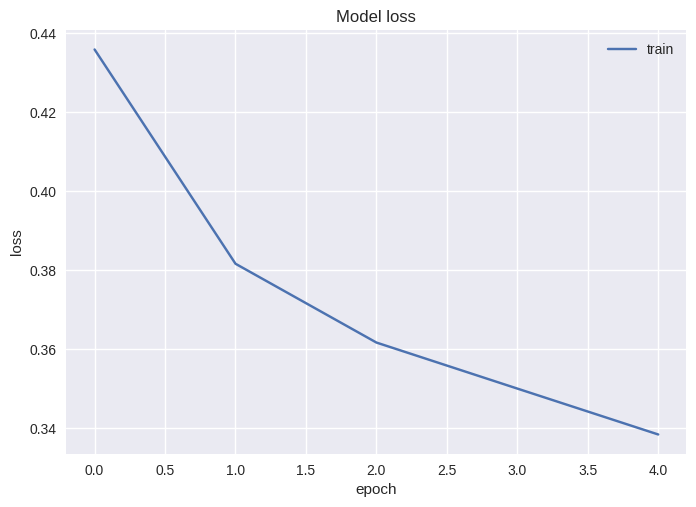

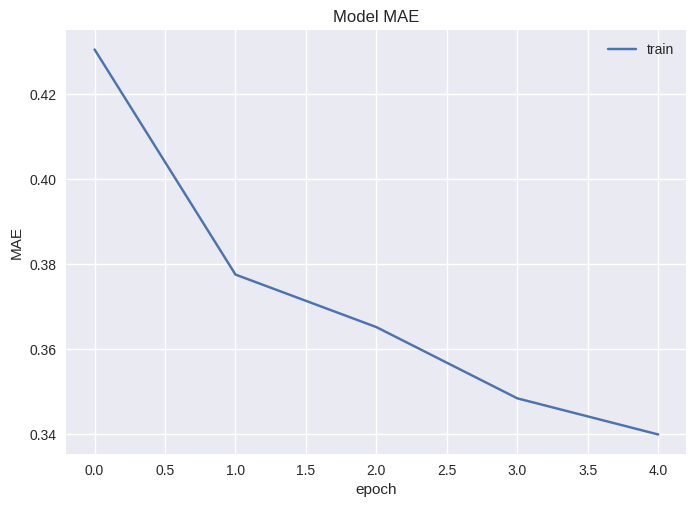

In [ ]:
visualization(history)

In [ ]:
model_save = model

### Predicción testing 2016

In [ ]:
output_steps = 1
batch_size = 1
prediction_len = 10
window_size = sequence_length
n_sequences = 40

In [ ]:
prediction_seqs = prediccion_secuencias_multiples(model, prediction_len, dataset_testing, output_steps, window_size, n_sequences)

In [ ]:
len(prediction_seqs)

41

In [ ]:
plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset_testing, prediction_len)

## Comprobaciones

##### Codigo para obtener pesos del modelo

In [ ]:

# Obtener capa LSTM
lstm_layer = model.get_layer("lstm_1")

# Obtener los pesos y sesgos de la capa LSTM
# Obtener los pesos y sesgos de la capa LSTM
weights_biases_lstm = lstm_layer.get_weights()

# Dividir la lista en pesos y sesgos
weights_lstm = weights_biases_lstm[0]
biases_lstm = weights_biases_lstm[1]

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa LSTM:", weights_lstm)
print("Sesgos de la capa LSTM:", biases_lstm)

# Obtener capa densa
dense_layer = model.get_layer("dense")

# Obtener los pesos y sesgos de la capa densa
weights_dense, biases_dense = dense_layer.get_weights()

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa densa:", weights_dense)
print("Sesgos de la capa densa:", biases_dense)

### COMPILE
### ENTRENO MODELO


# Obtener capa LSTM
lstm_layer = model.get_layer("lstm_1")

# Obtener los pesos y sesgos de la capa LSTM
# Obtener los pesos y sesgos de la capa LSTM
weights_biases_lstm = lstm_layer.get_weights()

# Dividir la lista en pesos y sesgos
weights_lstm = weights_biases_lstm[0]
biases_lstm = weights_biases_lstm[1]

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa LSTM:", weights_lstm)
print("Sesgos de la capa LSTM:", biases_lstm)

# Obtener capa densa
dense_layer = model.get_layer("dense")

# Obtener los pesos y sesgos de la capa densa
weights_dense, biases_dense = dense_layer.get_weights()

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa densa:", weights_dense)
print("Sesgos de la capa densa:", biases_dense)

##### *Estudio estado interno epochs y  batches*

In [ ]:
from tensorflow.keras.callbacks import Callback

class StatefulLSTMStatesCallback(Callback):
    def __init__(self):
        super(StatefulLSTMStatesCallback, self).__init__()
        self.states = []  # Lista para almacenar los estados internos

    def on_epoch_end(self, epoch, logs=None):
        # Obtener los estados internos de la capa LSTM
        lstm_layer = self.model.get_layer('lstm_1')  # Asegúrate de cambiar 'lstm_layer' al nombre real de tu capa LSTM
        states = lstm_layer.states
        print(states)
        self.states.append(states)  # Almacena los estados internos al final de cada época

# Crea el callback
lstm_states_callback = StatefulLSTMStatesCallback()

In [ ]:
from tensorflow.keras.callbacks import Callback

class StatefulLSTMStatesCallbackBatch(Callback):
    def __init__(self):
        super(StatefulLSTMStatesCallbackBatch, self).__init__()
        self.states = []  # Lista para almacenar los estados internos

    def on_batch_begin(self, batch, logs=None):
        # Obtener los estados internos de la capa LSTM al inicio de cada batch
        lstm_layer = self.model.get_layer('lstm_1')  # Asegúrate de cambiar 'lstm_layer' al nombre real de tu capa LSTM
        states = lstm_layer.states
        print("### INICIO BATCH")
        print(states)  # Imprimir el estado interno al inicio de cada batch

    def on_batch_end(self, batch, logs=None):
        # Obtener los estados internos de la capa LSTM
        lstm_layer = self.model.get_layer('lstm_1')  # Asegúrate de cambiar 'lstm_layer' al nombre real de tu capa LSTM
        states = lstm_layer.states
        print("### FIN BATCH")
        print(states)
        self.states.append(states)  # Almacena los estados internos al final de cada batch

# Crea el callback
lstm_states_callback_batch = StatefulLSTMStatesCallbackBatch()

In [ ]:
inputs = keras.Input(batch_shape=(1, sequence_length, 1))
x = LSTM(1, stateful = True, name = "lstm_1")(inputs)
x = BatchNormalization()(x)
outputs = Dense(output_steps)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
history = model.fit(train_dataset,
  epochs=1, verbose=1, shuffle = False, callbacks = [lstm_states_callback_batch])

### INICIO BATCH
ListWrapper([<tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>])
### FIN BATCH
ListWrapper([<tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.3736195]], dtype=float32)>, <tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[4.289068]], dtype=float32)>])
  1/568 [..............................] - ETA: 31:06 - loss: 4.0000 - mae: 2.0000### INICIO BATCH
ListWrapper([<tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.3736195]], dtype=float32)>, <tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[4.289068]], dtype=float32)>])
### FIN BATCH
ListWrapper([<tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.04533346]], dtype=float32)>, <tf.Variable 'lstm_1/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[3.6292

In [ ]:
X_train.shape

(568, 65, 1)

In [ ]:
X_train[0].shape

(65, 1)

In [ ]:
# Ejemplo de prediccion
first_sequence = X_train[0].reshape(1, sequence_length, 1)
predictions = model.predict(first_sequence)
print(predictions)

1/1 [==============================] - 0s 480ms/step
[[2.6864192]]
